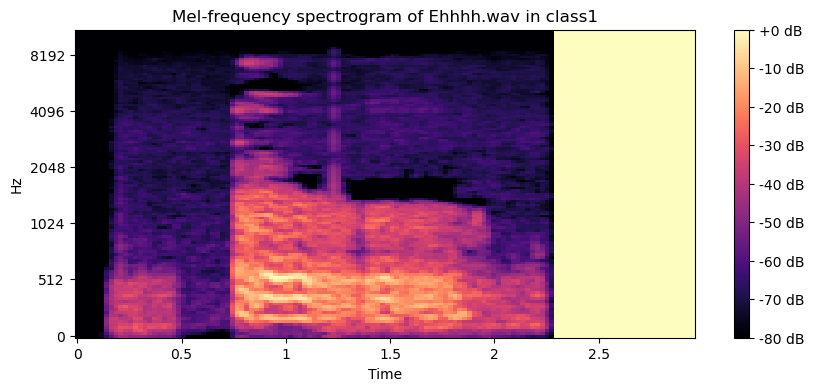

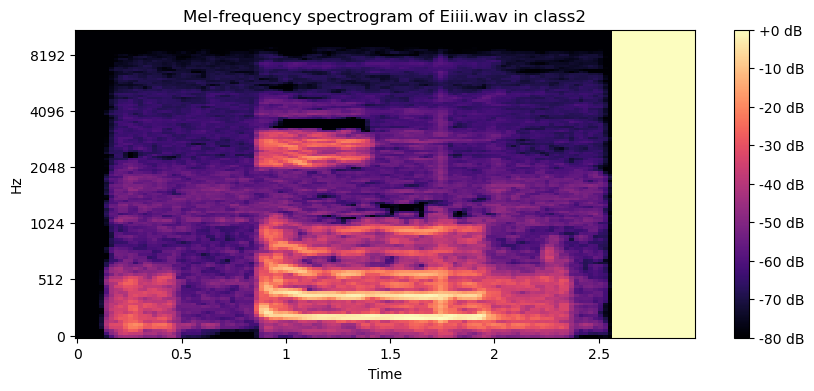

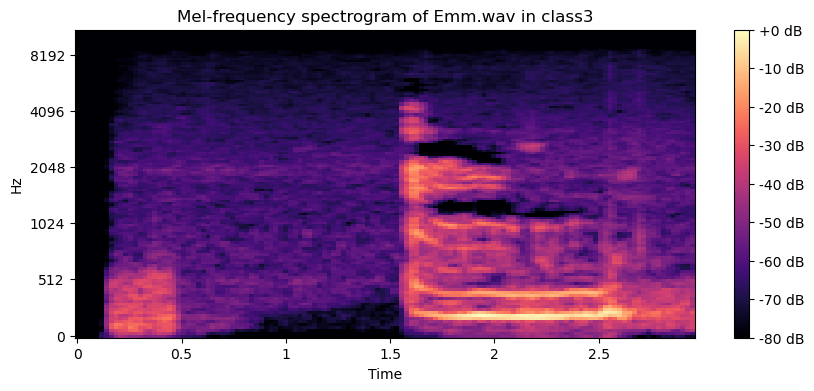

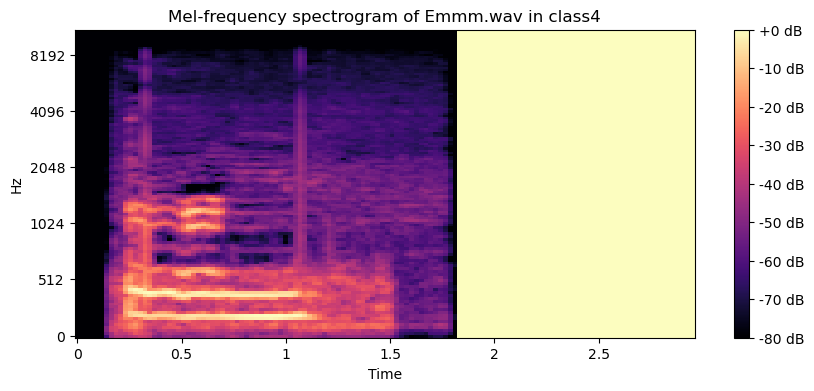

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# 定义音频文件路径和目标标签
data_dir = 'hesitation_voices'
target_classes = ['class1', 'class2', 'class3', 'class4']

# 提取Mel频谱图的函数
def extract_mel_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512, fixed_length=128):
    # 载入音频文件
    y, sr = librosa.load(file_path, sr=None)
    
    # 计算Mel频谱图
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    
    # 转换为dB（对数尺度）
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # 如果时间维度小于固定长度，则进行零填充
    if S_dB.shape[1] < fixed_length:
        padding = fixed_length - S_dB.shape[1]
        S_dB = np.pad(S_dB, pad_width=((0, 0), (0, padding)), mode='constant')
    # 如果时间维度大于固定长度，则进行裁剪
    elif S_dB.shape[1] > fixed_length:
        S_dB = S_dB[:, :fixed_length]
    
    return S_dB

# 遍历所有类别和文件并显示Mel频谱图
for class_name in target_classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(class_dir, file_name)
            
            # 提取Mel频谱图
            mel_spectrogram = extract_mel_spectrogram(file_path)
            
            # 可视化该Mel频谱图
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spectrogram, sr=22050, hop_length=512, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel-frequency spectrogram of {file_name} in {class_name}')
            plt.show()


In [3]:
import tensorflow as tf
import numpy as np

def load_image_features(img_paths=[]):
    # -----------------------------------------------------
    # Define tensorflow model
    # https://gist.github.com/eerwitt/518b0c9564e500b4b50f
    # -----------------------------------------------------
    # 定義 graph (tensor 和 flow)
    filename_queue = tf.train.string_input_producer(img_paths, shuffle=False)
    image_reader = tf.WholeFileReader()
    file_name, file_content = image_reader.read(filename_queue)
    decoded_image = tf.image.decode_png(file_content, channels=3)
    resized_image = tf.image.resize_images(decoded_image, [30, 30])

    final_image_ary = []
    # 執行 graph
    with tf.Session() as sess:
        # 執行tensorflow時要先初始化(初學者照抄即可!)
        init = tf.global_variables_initializer()
        sess.run(init)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord) # 建立多執行緒

        # image to RGB
        for i in range(len(img_paths)):
            img = sess.run(resized_image)
            final_image_ary.append(img)

        # 將最後的陣列轉換為 numpy 格式的陣列，以便存檔
        final_image_ary = np.array(final_image_ary, dtype=np.uint8)
        # 存檔
        final_image_ary.tofile("./your/image/training/array.features")

        # 停止多執行緒(初學者照抄前可!)
        coord.request_stop()
        coord.join(threads)

    return final_image_array

In [4]:
import tensorflow as tf
import numpy as np
import os

def load_image_features(img_paths=[]):
    image_list = []
    for img_path in img_paths:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [30, 30])
        img = img.numpy()  # 将 Tensor 转换为 numpy 数组
        image_list.append(img)
    
    final_image_ary = np.array(image_list, dtype=np.uint8)

    # 确保目录存在
    output_dir = "./your/image/training/"
    os.makedirs(output_dir, exist_ok=True)

    # 保存文件
    output_file = os.path.join(output_dir, "array.features")
    final_image_ary.tofile(output_file)
    
    return final_image_ary

# 示例用法
img_paths = [
    'output_spectrograms/class1_Ehhhh.wav.png',
    'output_spectrograms/class2_Eiiii.wav.png',
    'output_spectrograms/class3_Emm.wav.png',
    'output_spectrograms/class4_Emmm.wav.png'
]
load_image_features(img_paths)


array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# 设置 np 随机种子
np.random.seed(10)

# 载入训练数据集
n = 10000
img_feature = np.fromfile("./your/image/training/array.features", dtype=np.uint8)
print("Size of img_feature:", img_feature.size)

# 根据实际大小重塑形状
img_feature = img_feature.reshape(-1, 30, 30, 3)  # 自动计算第一维
img_label = np.fromfile("./your/image/training/array.labels", dtype=np.uint8)
img_label = img_label.reshape(-1, 1)  # 自动计算第一维

# 打散数据集
indexs = np.random.permutation(img_label.shape[0])
rand_img_feature = img_feature[indexs]
rand_img_label = img_label[indexs]

# 数据归一化
img_feature_normalized = rand_img_feature.reshape(rand_img_feature.shape[0], 30*30*3).astype('float32') / 255

# 将标签转换为 one-hot 表示
img_label_onehot = to_categorical(rand_img_label, num_classes=4)  # 4 个类别

# 创建一个线性堆叠模型
model = Sequential()

# 创建输入层与隐藏层
model.add(Dense(input_dim=30*30*3, # 输入层神经元数
                units=1000, # 隐藏层神经元数
                kernel_initializer='normal', # 权重和误差初始化方式:normal，使用常态分布产生初始值
                activation='relu')) # 激活函数:relu函数，忽略掉负数的值

# 创建输出层
model.add(Dense(units=4, # 输出层神经元数 (即 4 个类别)
                kernel_initializer='normal',
                activation='softmax')) # 激活函数:softmax函数，使输出介于 0~1 之间

# 定义训练方式
model.compile(loss='categorical_crossentropy', # 损失函数
              optimizer='adam', # 优化方法
              metrics=['accuracy']) # 评估方式:准确度

# 显示模型摘要
print(model.summary())

# 开始训练模型
train_history = model.fit(x=img_feature_normalized, # 指定特征
                          y=img_label_onehot, # 指定标签 
                          validation_split=0.2, # 分80%训练，20%验证
                          epochs=5, # 执行 5 次训练
                          batch_size=200, # 批次训练，每批次 200 条数据
                          verbose=2) # 显示训练过程

# 保存模型
model.save("./your/image/training/models.keras")  # 使用 .keras 扩展名


Size of img_feature: 10800


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1000)                │       2,701,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,705,004 (10.32 MB)

 Trainable params: 2,705,004 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/1 - 1s - 1s/step - accuracy: 0.3333 - loss: 1.2503 - val_accuracy: 0.0000e+00 - val_loss: 34.0120
Epoch 2/5
1/1 - 0s - 60ms/step - accuracy: 0.3333 - loss: 15.3967 - val_accuracy: 0.0000e+00 - val_loss: 35.2169
Epoch 3/5
1/1 - 0s - 61ms/step - accuracy: 0.3333 - loss: 8.3340 - val_accuracy: 0.0000e+00 - val_loss: 31.2791
Epoch 4/5
1/1 - 0s - 68ms/step - accuracy: 1.0000 - loss: 0.2082 - val_accuracy: 0.0000e+00 - val_loss: 35.6287
Epoch 5/5
1/1 - 0s - 64ms/step - accuracy: 0.3333 - loss: 2.7629 - val_accuracy: 0.0000e+00 - val_loss: 36.6789


In [6]:
#建立array.labels
import numpy as np
import os
import re

# 图片文件夹路径
image_folder = "output_spectrograms"

# 获取所有图片文件名
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# 提取类别并生成标签
labels = []
for file in image_files:
    # 提取类别名（假设类别名在文件名中，如 class1_）
    match = re.match(r'class(\d+)_', file)
    if match:
        label = int(match.group(1)) - 1  # 从 1 开始的类别，转为从 0 开始
        labels.append(label)

# 转换为 numpy 数组并保存为二进制文件
labels = np.array(labels, dtype=np.uint8).reshape(-1, 1)
labels.tofile("./your/image/training/array.labels")

print("Labels file generated successfully.")


Labels file generated successfully.


In [54]:
#新版用這個
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 假设你已经有 img_feature_normalized 的数据
# img_feature_normalized 形状为 (4, 2700)

# 重塑数据为 (num_samples, height, width, channels)
# 例如将 2700 转换为 270x10，并增加一个通道维度
img_feature_normalized = img_feature_normalized.reshape(4, 270, 10, 1)

# 创建一个卷积神经网络模型
model = Sequential()

# 创建第1层卷积层
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(img_feature_normalized.shape[1], img_feature_normalized.shape[2], img_feature_normalized.shape[3]),
                 activation='relu',
                 padding='same'))

# 在第1层卷积层加入 Dropout 层，避免过拟合
model.add(Dropout(rate=0.25))

# 创建第1层池化层
model.add(MaxPooling2D(pool_size=(2,2)))

# 创建第2层卷积层
model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu',
                 padding='same'))

# 在第2层卷积层加入 Dropout 层，避免过拟合
model.add(Dropout(rate=0.25))

# 创建第2层池化层
model.add(MaxPooling2D(pool_size=(2,2)))

# 创建平坦层
model.add(Flatten())
model.add(Dropout(rate=0.25))

# 创建有1920个神经元的隐藏层
model.add(Dense(1920, activation='relu'))
model.add(Dropout(rate=0.25))

# 创建有4个神经元的输出层
model.add(Dense(4, activation='softmax'))

# 定义训练方式
model.compile(loss='categorical_crossentropy', # 损失函数
              optimizer='adam', # 优化方法
              metrics=['accuracy']) # 评估方式:准确度

# 显示模型摘要
print(model.summary())

# 开始训练模型
train_history = model.fit(x=img_feature_normalized, # 指定特征
                          y=img_label_onehot, # 指定标签 
                          validation_split=0.2, # 分80%训练，20%验证
                          epochs=5, # 执行5次训练
                          batch_size=200, # 批次训练，每批次200条数据
                          verbose=2) # 显示训练过程

# 保存模型
model.save("./your/model/path/model.keras")  # 使用 .keras 扩展名


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 270, 10, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 270, 10, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 135, 5, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 135, 5, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 135, 5, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 67, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 8576)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 8576)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1920)                │      16,467,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │           7,684 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,494,340 (62.92 MB)

 Trainable params: 16,494,340 (62.92 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/1 - 3s - 3s/step - accuracy: 0.0000e+00 - loss: 1.5939 - val_accuracy: 0.0000e+00 - val_loss: 5.5765
Epoch 2/5
1/1 - 0s - 443ms/step - accuracy: 0.3333 - loss: 1.0965 - val_accuracy: 0.0000e+00 - val_loss: 8.0289
Epoch 3/5
1/1 - 0s - 180ms/step - accuracy: 0.6667 - loss: 1.1494 - val_accuracy: 0.0000e+00 - val_loss: 9.3147
Epoch 4/5
1/1 - 0s - 179ms/step - accuracy: 0.3333 - loss: 0.9681 - val_accuracy: 0.0000e+00 - val_loss: 10.0285
Epoch 5/5
1/1 - 0s - 189ms/step - accuracy: 0.6667 - loss: 1.3329 - val_accuracy: 0.0000e+00 - val_loss: 9.6383


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

# 设定 np 随机种子
np.random.seed(10)

# 假设您已经处理并定义了这些数据
# img_feature_normalized 和 img_label_onehot 需要在这之前定义

# 创建一个卷积神经网络模型
model = Sequential()

# 创建第1层卷积层，通过滤镜产生32个图像特征
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(img_feature_normalized.shape[1], img_feature_normalized.shape[2], img_feature_normalized.shape[3]),
                 activation='relu',
                 padding='same'))

# 在第1层卷积层加入 Dropout 层，避免过拟合
model.add(Dropout(rate=0.25))

# 创建第1层池化层，将32x32图像，缩小为16x16图像
model.add(MaxPooling2D(pool_size=(2,2)))

# 创建第2层卷积层，通过滤镜产生64个图像特征
model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu',
                 padding='same'))

# 在第2层卷积层加入 Dropout 层，避免过拟合
model.add(Dropout(rate=0.25))

# 创建第2层池化层，将16x16图像，缩小为8x8图像
model.add(MaxPooling2D(pool_size=(2,2)))

# 创建平坦层，将64个8x8图像转换为一维向量，64*8*8=4096个数字
model.add(Flatten())
model.add(Dropout(rate=0.25))

# 创建有1920个神经元的隐藏层
model.add(Dense(1920, activation='relu'))
model.add(Dropout(rate=0.25))

# 创建有4个神经元的输出层
model.add(Dense(4, activation='softmax'))

# 定义训练方式
model.compile(loss='categorical_crossentropy', # 损失函数
              optimizer='adam', # 优化方法
              metrics=['accuracy']) # 评估方式:准确度

# 显示模型摘要
print(model.summary())

# 开始训练模型
train_history = model.fit(x=img_feature_normalized, # 指定特征
                          y=img_label_onehot, # 指定标签 
                          validation_split=0.2, # 分80%训练，20%验证
                          epochs=5, # 执行5次训练
                          batch_size=200, # 批次训练，每批次200条数据
                          verbose=2) # 显示训练过程

# 保存模型
model.save("./your/model/path/model.keras")  # 使用 .keras 扩展名

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 270, 10, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 270, 10, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 135, 5, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 135, 5, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 135, 5, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 67, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8576)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 8576)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1920)                │      16,467,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           7,684 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,494,340 (62.92 MB)

 Trainable params: 16,494,340 (62.92 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1/1 - 1s - 1s/step - accuracy: 0.0000e+00 - loss: 1.5594 - val_accuracy: 0.0000e+00 - val_loss: 6.7986
Epoch 2/5
1/1 - 0s - 128ms/step - accuracy: 0.3333 - loss: 1.1764 - val_accuracy: 0.0000e+00 - val_loss: 9.9508
Epoch 3/5
1/1 - 0s - 121ms/step - accuracy: 0.0000e+00 - loss: 3.0533 - val_accuracy: 0.0000e+00 - val_loss: 10.1290
Epoch 4/5
1/1 - 0s - 115ms/step - accuracy: 0.3333 - loss: 1.4544 - val_accuracy: 0.0000e+00 - val_loss: 9.3773
Epoch 5/5
1/1 - 0s - 121ms/step - accuracy: 0.6667 - loss: 0.8835 - val_accuracy: 0.0000e+00 - val_loss: 9.2070


In [8]:
print("Shape of img_feature_normalized:", img_feature_normalized.shape)


Shape of img_feature_normalized: (4, 2700)


In [9]:
# 将扁平数据重新调整为 (4, 30, 30, 3) 的形状
img_feature = img_feature_normalized.reshape(4, 30, 30, 3)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

# 假设您已经处理并定义了这些数据
# img_feature 和 img_label_onehot 需要在这之前定义

# 创建一个卷积神经网络模型
model = Sequential()

# 创建第1层卷积层，通过滤镜产生32个图像特征
# 确保 input_shape 是 (height, width, channels)
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(30, 30, 3),
                 activation='relu',
                 padding='same'))

# 在第1层卷积层加入 Dropout 层，避免过拟合
model.add(Dropout(rate=0.25))

# 创建第1层池化层，将30x30图像，缩小为15x15图像
model.add(MaxPooling2D(pool_size=(2,2)))

# 创建第2层卷积层，通过滤镜产生64个图像特征
model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu',
                 padding='same'))

# 在第2层卷积层加入 Dropout 层，避免过拟合
model.add(Dropout(rate=0.25))

# 创建第2层池化层，将15x15图像，缩小为7x7图像
model.add(MaxPooling2D(pool_size=(2,2)))

# 创建平坦层，将64个7x7图像转换为一维向量，64*7*7=3136个数字
model.add(Flatten())
model.add(Dropout(rate=0.25))

# 创建有1920个神经元的隐藏层
model.add(Dense(1920, activation='relu'))
model.add(Dropout(rate=0.25))

# 创建有4个神经元的输出层
model.add(Dense(4, activation='softmax'))

# 定义训练方式
model.compile(loss='categorical_crossentropy', # 损失函数
              optimizer='adam', # 优化方法
              metrics=['accuracy']) # 评估方式:准确度

# 显示模型摘要
print(model.summary())

# 开始训练模型
train_history = model.fit(x=img_feature, # 指定特征
                          y=img_label_onehot, # 指定标签 
                          validation_split=0.2, # 分80%训练，20%验证
                          epochs=5, # 执行5次训练
                          batch_size=1, # 批次训练，每批次1条数据（因为数据量很小，使用小批次）
                          verbose=2) # 显示训练过程

# 保存模型
model.save("./your/model/path/model.keras")  # 使用 .keras 扩展名


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1920)                │       6,023,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           7,684 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,050,116 (23.08 MB)

 Trainable params: 6,050,116 (23.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
3/3 - 1s - 466ms/step - accuracy: 0.3333 - loss: 4.6994 - val_accuracy: 0.0000e+00 - val_loss: 3.4358
Epoch 2/5
3/3 - 0s - 43ms/step - accuracy: 0.0000e+00 - loss: 2.1917 - val_accuracy: 0.0000e+00 - val_loss: 2.7383
Epoch 3/5
3/3 - 0s - 43ms/step - accuracy: 0.3333 - loss: 1.3551 - val_accuracy: 0.0000e+00 - val_loss: 2.1973
Epoch 4/5
3/3 - 0s - 44ms/step - accuracy: 0.3333 - loss: 0.9512 - val_accuracy: 0.0000e+00 - val_loss: 2.3538
Epoch 5/5
3/3 - 0s - 41ms/step - accuracy: 0.3333 - loss: 1.1651 - val_accuracy: 0.0000e+00 - val_loss: 2.6830


In [14]:
import os

# 定义路径
model_dir = "./your/model/path/"

# 创建目录（如果目录不存在）
os.makedirs(model_dir, exist_ok=True)

# 保存模型
model.save(os.path.join(model_dir, "model.keras"))
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\User


In [18]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 显示统计结果
    result = {class_labels.get(cls, 'Unknown'): count for cls, count in counts.items()}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")

    # 如果需要，可以显示预测图像
    for img_path in img_paths:
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['Lucy_confident.wav.png', 'another_image.png']  # 图像路径
target_size = (270, 10)  # 根据模型输入大小调整

predict_and_statistic(model_path, img_paths, target_size)


FileNotFoundError: [Errno 2] No such file or directory: 'Lucy_confident.wav.png'

Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction Statistics:
class3_Emm: 1


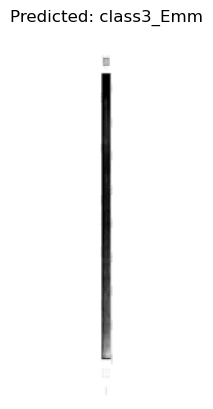

In [22]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 显示统计结果
    result = {class_labels.get(cls, 'Unknown'): count for cls, count in counts.items()}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")

    # 如果需要，可以显示预测图像
    for img_path in img_paths:
        img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
        img = img.resize(target_size)  # 调整图像大小
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['main_voices_spectrograms/Lucy_unconfident.mp4.png']  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


In [19]:
print("Model input shape:", model.input_shape)


Model input shape: (None, 270, 10, 1)


Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediction Statistics:
class1_Ehhhh: 0
class2_Eiiii: 0
class3_Emm: 1
class4_Emmm: 0


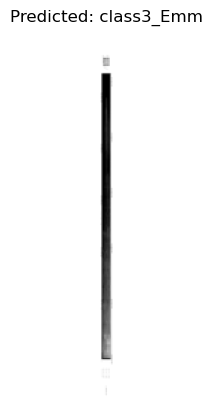

In [26]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 确保所有类别都被输出
    all_classes = set(class_labels.keys())
    result = {class_labels.get(cls, 'Unknown'): counts.get(cls, 0) for cls in all_classes}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")

    # 如果需要，可以显示预测图像
    for img_path in img_paths:
        img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
        img = img.resize(target_size)  # 调整图像大小
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['main_voices_spectrograms/Lucy_a bit confident.png']  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predictions for main_voices_spectrograms/Lucy_a bit confident.png: [[0.20888264 0.00158114 0.50053144 0.2890048 ]]
Prediction Statistics:
class1_Ehhhh: 0
class2_Eiiii: 0
class3_Emm: 1
class4_Emmm: 0


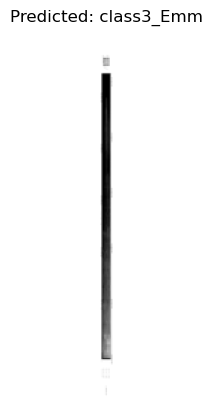

In [27]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        
        # 打印预测输出
        print(f"Predictions for {img_path}: {predictions}")
        
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 确保所有类别都被输出
    all_classes = set(class_labels.keys())
    result = {class_labels.get(cls, 'Unknown'): counts.get(cls, 0) for cls in all_classes}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")

    # 如果需要，可以显示预测图像
    for img_path in img_paths:
        img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
        img = img.resize(target_size)  # 调整图像大小
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['main_voices_spectrograms/Lucy_a bit confident.png']  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predictions for main_voices_spectrograms/Lucy_a bit confident.png: [[0.20888264 0.00158114 0.50053144 0.2890048 ]]
Prediction Statistics:
class1_Ehhhh: 0
class2_Eiiii: 0
class3_Emm: 1
class4_Emmm: 0


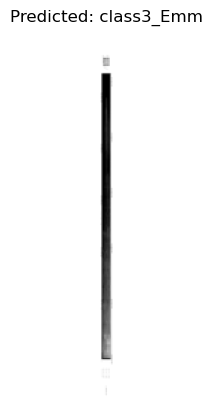

In [28]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        
        # 打印预测输出
        print(f"Predictions for {img_path}: {predictions}")
        
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 确保所有类别都被输出
    all_classes = set(class_labels.keys())
    result = {class_labels.get(cls, 'Unknown'): counts.get(cls, 0) for cls in all_classes}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")

    # 如果需要，可以显示预测图像
    for img_path in img_paths:
        img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
        img = img.resize(target_size)  # 调整图像大小
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = []  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predictions for main_voices_spectrograms/Lucy_a bit confident.png: [[0.20888264 0.00158114 0.50053144 0.2890048 ]]
Prediction Statistics:
class1_Ehhhh: 0
class2_Eiiii: 0
class3_Emm: 1
class4_Emmm: 0


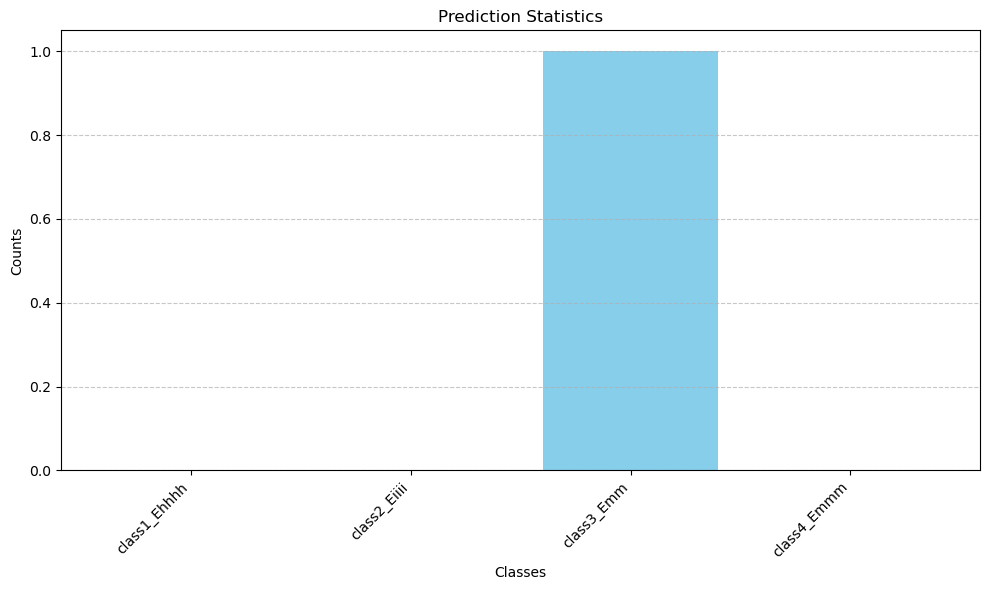

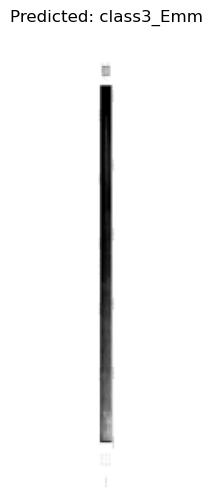

In [29]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        
        # 打印预测输出
        print(f"Predictions for {img_path}: {predictions}")
        
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 确保所有类别都被输出
    all_classes = set(class_labels.keys())
    result = {class_labels.get(cls, 'Unknown'): counts.get(cls, 0) for cls in all_classes}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")
    
    # 可视化统计结果
    plt.figure(figsize=(10, 6))
    plt.bar(result.keys(), result.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('Prediction Statistics')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 可视化预测图像
        for img_path in img_paths:
        img_array = preprocess_image(img_path, target_size)
        img = np.squeeze(img_array)  # 去除多余的维度
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['main_voices_spectrograms/Lucy_a bit confident.png']  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Predictions for main_voices_spectrograms/Lucy_confident.png: [[0.20729233 0.00161123 0.50382066 0.28727582]]
Prediction Statistics:
class1_Ehhhh: 0
class2_Eiiii: 0
class3_Emm: 1
class4_Emmm: 0


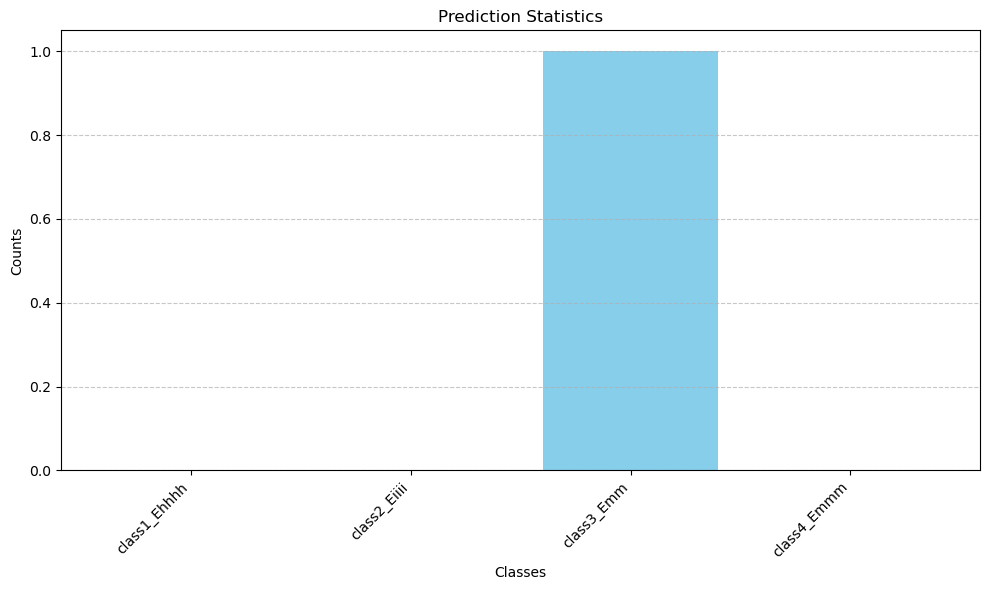

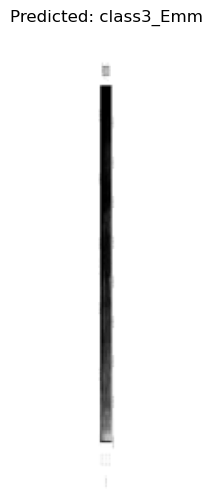

In [30]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        
        # 进行预测
        predictions = model.predict(img_array)
        
        # 打印预测输出
        print(f"Predictions for {img_path}: {predictions}")
        
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 确保所有类别都被输出
    all_classes = set(class_labels.keys())
    result = {class_labels.get(cls, 'Unknown'): counts.get(cls, 0) for cls in all_classes}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")
    
    # 可视化统计结果
    plt.figure(figsize=(10, 6))
    plt.bar(result.keys(), result.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('Prediction Statistics')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 可视化预测图像
    for img_path in img_paths:
        img_array = preprocess_image(img_path, target_size)
        img = np.squeeze(img_array)  # 去除多余的维度
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['main_voices_spectrograms/Lucy_confident.png']  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


Model input shape: (None, 270, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predictions for main_voices_spectrograms/Lucy_unconfident.mp4.png: [[0.20842746 0.0015805  0.5001705  0.2898215 ]]
Prediction Statistics:
class1_Ehhhh: 0
class2_Eiiii: 0
class3_Emm: 1
class4_Emmm: 0


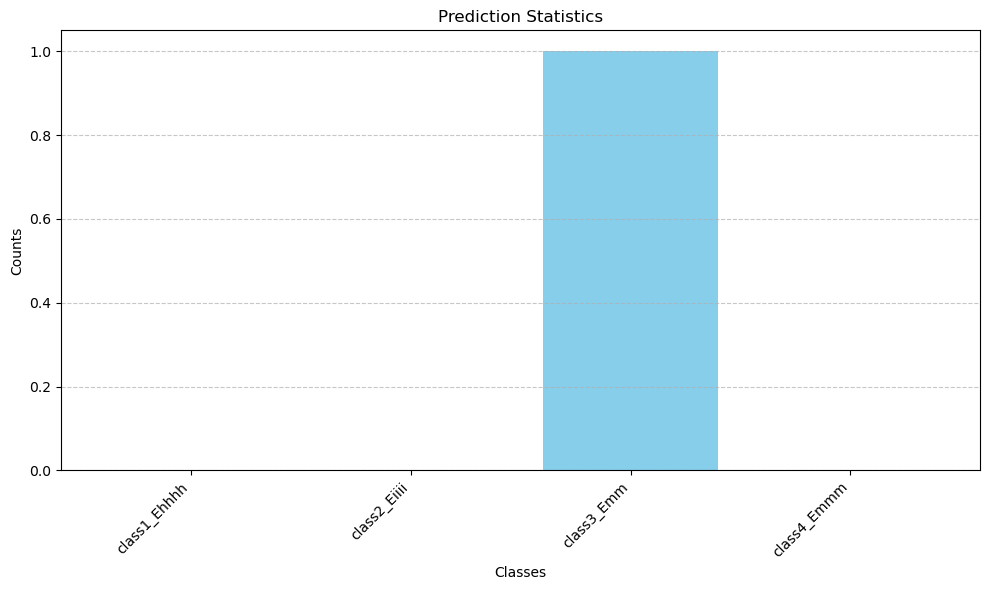

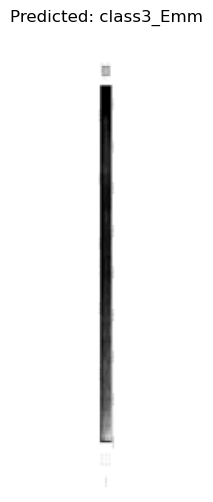

In [34]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from collections import Counter

def preprocess_image(img_path, target_size):
    """加载和预处理图像"""
    img = image.load_img(img_path, color_mode='grayscale')  # 如果模型期望单通道图像
    img = img.resize(target_size)  # 调整图像大小
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次维度
    img_array /= 255.0  # 归一化
    return img_array

def predict_and_statistic(model_path, img_paths, target_size):
    """使用模型进行预测并统计结果"""
    # 加载模型
    model = load_model(model_path)
    
    # 打印模型输入形状
    print("Model input shape:", model.input_shape)
    
    # 存储所有预测结果
    all_predictions = []
    
    for img_path in img_paths:
        # 预处理图像
        img_array = preprocess_image(img_path, target_size)
        #for 
        # 进行预测
        predictions = model.predict(img_array)
        
        # 打印预测输出
        print(f"Predictions for {img_path}: {predictions}")
        #argmax 更改
        predicted_class = np.argmax(predictions, axis=1)[0]
        all_predictions.append(predicted_class)
    
    # 统计结果
    class_labels = {
        0: 'class1_Ehhhh',
        1: 'class2_Eiiii',
        2: 'class3_Emm',
        3: 'class4_Emmm',
        # 根据实际情况添加更多的类别
    }
    
    # 统计每个类别的出现次数
    counts = Counter(all_predictions)
    
    # 确保所有类别都被输出
    all_classes = set(class_labels.keys())
    result = {class_labels.get(cls, 'Unknown'): counts.get(cls, 0) for cls in all_classes}
    
    # 打印结果
    print("Prediction Statistics:")
    for label, count in result.items():
        print(f"{label}: {count}")
    
    # 可视化统计结果
    plt.figure(figsize=(10, 6))
    plt.bar(result.keys(), result.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('Prediction Statistics')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 可视化预测图像
    for img_path in img_paths:
        img_array = preprocess_image(img_path, target_size)
        img = np.squeeze(img_array)  # 去除多余的维度
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')  # 使用灰度色图显示
        plt.title(f"Predicted: {class_labels[np.argmax(predictions)]}")
        plt.axis('off')
        plt.show()

# 示例使用
model_path = './your/model/path/model.keras'  # 模型路径
img_paths = ['main_voices_spectrograms/Lucy_unconfident.mp4.png']  # 图像路径
target_size = (10, 270)  # 根据模型输入大小调整，注意顺序为 (width, height)

predict_and_statistic(model_path, img_paths, target_size)


In [113]:
from PIL import Image
import os

def split_spectrogram(image_path, output_folder, time_per_segment, pixels_per_second):
    # 開啟原始圖像
    image = Image.open(image_path)
    width, height = image.size

    # 計算每個片段的寬度（時間軸上的像素數）
    segment_width = int(time_per_segment * pixels_per_second)
    
    # 計算片段的數量
    num_segments = width // segment_width
    
    # 確保輸出資料夾存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 分割圖像並保存每個片段
    for i in range(num_segments):
        left = i * segment_width
        right = (i + 1) * segment_width
        segment = image.crop((left, 0, right, height))
        segment.save(os.path.join(output_folder, f'segment_{i + 1}.png'))
    
    # 處理剩餘部分（如果有）
    if width % segment_width != 0:
        left = num_segments * segment_width
        right = width
        segment = image.crop((left, 0, right, height))
        segment.save(os.path.join(output_folder, f'segment_{num_segments + 1}.png'))

# 使用範例
image_path = 'main_voices_spectrograms/Lucy_a bit confident.png'  # 請替換成你的文件路徑
output_folder = 'split_main_audio_abitconfident'
time_per_segment = 4  # 每個片段代表2秒
pixels_per_second = 1.65  # 每秒對應100個像素，請根據實際數據進行調整

split_spectrogram(image_path, output_folder, time_per_segment, pixels_per_second)


In [114]:
from tensorflow.keras.models import load_model

# 加載預訓練的 CNN 模型
model = load_model('your/model/path/model.keras')

import numpy as np
from PIL import Image

def preprocess_image(image_path, target_shape=(270, 10, 1)):
    # 打開並轉換圖像為灰度圖（單通道）
    image = Image.open(image_path).convert('L')
    
    # 調整圖像大小
    image = image.resize((target_shape[1], target_shape[0]))
    
    # 將圖像轉換為 numpy 數組並進行標準化
    image_array = np.array(image) / 255.0
    
    # 添加頻道維度
    image_array = image_array.reshape(target_shape)
    
    return image_array


In [115]:
import os

def predict_segments(model, segments_folder, threshold=0.5):
    target_classes = ["class1", "class2", "class3", "class4"]
    match_count = {target: 0 for target in target_classes}
    
    # 遍歷所有裁切後的圖像片段
    for segment_name in os.listdir(segments_folder):
        segment_path = os.path.join(segments_folder, segment_name)
        
        # 忽略非圖像文件或隱藏文件夾
        if not segment_name.endswith('.png'):
            continue
        
        # 預處理圖像
        image_array = preprocess_image(segment_path)
        
        # 增加批次維度以符合模型輸入
        image_array = np.expand_dims(image_array, axis=0)
        
        # 預測
        predictions = model.predict(image_array)
        
        # 檢查預測結果，判斷是否符合目標聲音
        for i, target in enumerate(target_classes):
            if predictions[0][i] >= threshold:
                match_count[target] += 1
    
    return match_count



In [117]:
segments_folder = 'split_main_audio_abitconfident'  # 存放裁切後片段的資料夾
result = predict_segments(model, segments_folder, threshold=0.5)

print("符合或大致符合 target voice 的片段數量：")
for target, count in result.items():
    print(f"{target}: {count} 個片段")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [108]:
from PIL import Image
import os

def split_spectrogram(image_path, output_folder, time_per_segment, pixels_per_second):
    # 開啟原始圖像
    image = Image.open(image_path)
    width, height = image.size

    # 計算每個片段的寬度（時間軸上的像素數）
    segment_width = int(time_per_segment * pixels_per_second)
    
    # 計算片段的數量
    num_segments = width // segment_width
    
    # 確保輸出資料夾存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 分割圖像並保存每個片段
    for i in range(num_segments):
        left = i * segment_width
        right = (i + 1) * segment_width
        segment = image.crop((left, 0, right, height))
        segment.save(os.path.join(output_folder, f'segment_{i + 1}.png'))
    
    # 處理剩餘部分（如果有）
    if width % segment_width != 0:
        left = num_segments * segment_width
        right = width
        segment = image.crop((left, 0, right, height))
        segment.save(os.path.join(output_folder, f'segment_{num_segments + 1}.png'))

# 使用範例
image_path = 'main_voices_spectrograms/Lucy_confident.png'  # 請替換成你的文件路徑
output_folder = 'split_main_aduio_confident'
time_per_segment = 4  # 每個片段代表2秒
pixels_per_second = 1.73  # 每秒對應像素，請根據實際數據進行調整

split_spectrogram(image_path, output_folder, time_per_segment, pixels_per_second)


In [112]:
from tensorflow.keras.models import load_model
import os

def predict_segments(model, segments_folder, threshold=0.5):
    target_classes = ["class1", "class2", "class3", "class4"]
    match_count = {target: 0 for target in target_classes}
    
    # 遍歷所有裁切後的圖像片段
    for segment_name in os.listdir(segments_folder):
        segment_path = os.path.join(segments_folder, segment_name)
        
        # 忽略非圖像文件或隱藏文件夾
        if not segment_name.endswith('.png'):
            continue
        
        # 預處理圖像
        image_array = preprocess_image(segment_path)
        
        # 增加批次維度以符合模型輸入
        image_array = np.expand_dims(image_array, axis=0)
        
        # 預測
        predictions = model.predict(image_array)
        
        # 檢查預測結果，判斷是否符合目標聲音
        for i, target in enumerate(target_classes):
            if predictions[0][i] >= threshold:
                match_count[target] += 1
    
    return match_count


# 加載預訓練的 CNN 模型
model = load_model('your/model/path/model.keras')

import numpy as np
from PIL import Image

def preprocess_image(image_path, target_shape=(270, 10, 1)):
    # 打開並轉換圖像為灰度圖（單通道）
    image = Image.open(image_path).convert('L')
    
    # 調整圖像大小
    image = image.resize((target_shape[1], target_shape[0]))
    
    # 將圖像轉換為 numpy 數組並進行標準化
    image_array = np.array(image) / 255.0
    
    # 添加頻道維度
    image_array = image_array.reshape(target_shape)
    
    return image_array
import os

def predict_segments(model, segments_folder, threshold=0.5):
    target_classes = ["class1", "class2", "class3", "class4"]
    match_count = {target: 0 for target in target_classes}
    
    # 遍歷所有裁切後的圖像片段
    for segment_name in os.listdir(segments_folder):
        segment_path = os.path.join(segments_folder, segment_name)
        
        # 忽略非圖像文件或隱藏文件夾
        if not segment_name.endswith('.png'):
            continue
        
        # 預處理圖像
        image_array = preprocess_image(segment_path)
        
        # 增加批次維度以符合模型輸入
        image_array = np.expand_dims(image_array, axis=0)
        
        # 預測
        predictions = model.predict(image_array)
        
        # 檢查預測結果，判斷是否符合目標聲音
        for i, target in enumerate(target_classes):
            if predictions[0][i] >= threshold:
                match_count[target] += 1
    
    return match_count

segments_folder = 'split_main_aduio_confident'  # 存放裁切後片段的資料夾
result = predict_segments(model, segments_folder, threshold=0.5)

print("符合或大致符合 target voice 的片段數量：")
for target, count in result.items():
    print(f"{target}: {count} 個片段")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [106]:
from PIL import Image
import os

def split_spectrogram(image_path, output_folder, time_per_segment, pixels_per_second):
    # 開啟原始圖像
    image = Image.open(image_path)
    width, height = image.size

    # 計算每個片段的寬度（時間軸上的像素數）
    segment_width = int(time_per_segment * pixels_per_second)
    
    # 計算片段的數量
    num_segments = width // segment_width
    
    # 確保輸出資料夾存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 分割圖像並保存每個片段
    for i in range(num_segments):
        left = i * segment_width
        right = (i + 1) * segment_width
        segment = image.crop((left, 0, right, height))
        segment.save(os.path.join(output_folder, f'segment_{i + 1}.png'))
    
    # 處理剩餘部分（如果有）
    if width % segment_width != 0:
        left = num_segments * segment_width
        right = width
        segment = image.crop((left, 0, right, height))
        segment.save(os.path.join(output_folder, f'segment_{num_segments + 1}.png'))

# 使用範例
image_path = 'main_voices_spectrograms/Lucy_unconfident.mp4.png'  # 請替換成你的文件路徑
output_folder = 'split_main_audio_unconfident'
time_per_segment = 4   #每個片段代表2秒
pixels_per_second = 2.35  # 每秒對應像素，請根據實際數據進行調整

split_spectrogram(image_path, output_folder, time_per_segment, pixels_per_second)


In [118]:
from tensorflow.keras.models import load_model
import os

def predict_segments(model, segments_folder, threshold=0.5):
    target_classes = ["class1", "class2", "class3", "class4"]
    match_count = {target: 0 for target in target_classes}
    
    # 遍歷所有裁切後的圖像片段
    for segment_name in os.listdir(segments_folder):
        segment_path = os.path.join(segments_folder, segment_name)
        
        # 忽略非圖像文件或隱藏文件夾
        if not segment_name.endswith('.png'):
            continue
        
        # 預處理圖像
        image_array = preprocess_image(segment_path)
        
        # 增加批次維度以符合模型輸入
        image_array = np.expand_dims(image_array, axis=0)
        
        # 預測
        predictions = model.predict(image_array)
        
        # 檢查預測結果，判斷是否符合目標聲音
        for i, target in enumerate(target_classes):
            if predictions[0][i] >= threshold:
                match_count[target] += 1
    
    return match_count


# 加載預訓練的 CNN 模型
model = load_model('your/model/path/model.keras')

import numpy as np
from PIL import Image

def preprocess_image(image_path, target_shape=(270, 10, 1)):
    # 打開並轉換圖像為灰度圖（單通道）
    image = Image.open(image_path).convert('L')
    
    # 調整圖像大小
    image = image.resize((target_shape[1], target_shape[0]))
    
    # 將圖像轉換為 numpy 數組並進行標準化
    image_array = np.array(image) / 255.0
    
    # 添加頻道維度
    image_array = image_array.reshape(target_shape)
    
    return image_array
import os

def predict_segments(model, segments_folder, threshold=0.5):
    target_classes = ["class1", "class2", "class3", "class4"]
    match_count = {target: 0 for target in target_classes}
    
    # 遍歷所有裁切後的圖像片段
    for segment_name in os.listdir(segments_folder):
        segment_path = os.path.join(segments_folder, segment_name)
        
        # 忽略非圖像文件或隱藏文件夾
        if not segment_name.endswith('.png'):
            continue
        
        # 預處理圖像
        image_array = preprocess_image(segment_path)
        
        # 增加批次維度以符合模型輸入
        image_array = np.expand_dims(image_array, axis=0)
        
        # 預測
        predictions = model.predict(image_array)
        
        # 檢查預測結果，判斷是否符合目標聲音
        for i, target in enumerate(target_classes):
            if predictions[0][i] >= threshold:
                match_count[target] += 1
    
    return match_count

segments_folder = 'split_main_audio_unconfident'  # 存放裁切後片段的資料夾
result = predict_segments(model, segments_folder, threshold=0.3)

print("符合或大致符合 target voice 的片段數量：")
for target, count in result.items():
    print(f"{target}: {count} 個片段")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━